### Classificação de Diabetes utilizando Regressão Logística e Random Forest

### Realizando treinamento, avaliação e interpretação de modelos preditivos para classificação de diabetes, utilizando o dataset Pima Indians Diabetes.

### Os modelos implementados são: Regressão Logística e Random Forest, com pré-processamento completo, balanceamento de classes via SMOTE, análise exploratória de dados (EDA), avaliação com métricas de classificação e visualização da importância das features.

In [ ]:
# Instalando requisitos
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn joblib


In [30]:
#Import bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # Para lidar com desbalanceamento

#Carregando o dataset Salvo localmente na máquina (o arquivo está dentro da pasta data, porém, é necessário colocar o caminho anterior com de acordo aonde foi salvo na sua máquina)
df = pd.read_csv('../data/diabetes.csv')

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

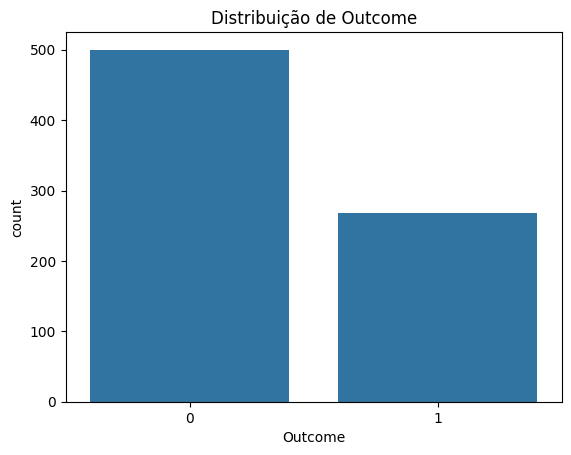

In [31]:
############    inspecionando os dados    ############
print(df.head())
print(df.info())
print(df.describe())

sns.countplot(x='Outcome', data=df)
plt.title("Distribuição de Outcome")
plt.show()


  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1                     0.167   21        0
4            0      137             40             35      168  43.1                     2.288   33        1

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin         BMI  DiabetesPedigreeFunction         Age     Outcome
count   768.000000  768.000000     768.000000     768.000000  768.000000  768.000000                768.000000  768.000000  768.000000
mean      3.845052  120.894531      69.105469      20.536458   79.799479   31.992578                  0.471876   33.240885    0.348958
std       3.369578   31.972618      19.355807      15.952218  115.244002    7.884160                  0.331329   11.760232    0.476951
min       0.000000    0.000000       0.000000       0.000000    0.000000    0.000000                  0.078000   21.000000    0.000000
25%       1.000000   99.000000      62.000000       0.000000    0.000000   27.300000                  0.243750   24.000000    0.000000
50%       3.000000  117.000000      72.000000      23.000000   30.500000   32.000000                  0.372500   29.000000    0.000000
75%       6.000000  140.250000      80.000000      32.000000  127.250000   36.600000                  0.626250   41.000000    1.000000
max      17.000000  199.000000     122.000000      99.000000  846.000000   67.100000                  2.420000   81.000000    1.000000

Carregando mapa de Correlação, para verificar quais dados tem mais relação com outro, 
exemplo, quando uma pessoa tem diabetes, se ela tem a glicose alta, a espessura da pele também aumenta,
esse mapa valida esse tipo de detalhe

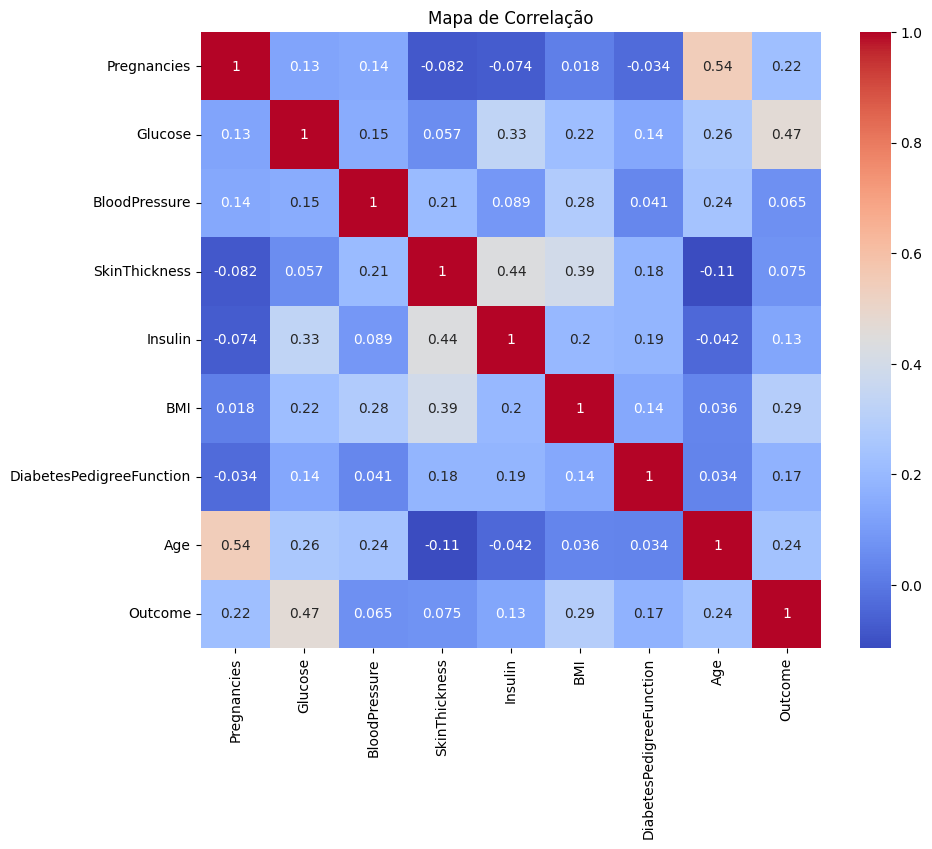

In [32]:
# -----------------------------
#    Mapa de Correlação
# -----------------------------
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Mapa de Correlação")
plt.show()

Algumas colunas do dataset contêm o valor 0, mas nesse contexto, 0 não representa um resultado real, 
e sim a ausência de medição (ex.: zero de Insulina ou BMI não faz sentido fisiologicamente).
Portanto, substituímos os zeros por NaN (not a number).
Em seguida, preenchemos esses valores nulos com a mediana da coluna, preservando a distribuição dos dados
e evitando distorções que poderiam prejudicar o treinamento do modelo.
Por fim, padronizamos as features usando StandardScaler, facilitando a convergência e o desempenho dos modelos de Machine Learning.

In [33]:
############    Normalizando os dados    ############
cols_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols_zero] = df[cols_zero].replace(0, np.nan)
print(df.isnull().sum())
df.fillna(df.median(), inplace=True)

X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


ao utilizar o "print(df.isnull()), estamos somando quantos itens nulos temos por coluna, que resulta assim:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [34]:
# -----------------------------
#    Dividindo treino e teste
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [35]:
# -----------------------------
#  lidando com o desbalanceamento
# -----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [36]:
# -----------------------------
#   Parte de treinamento
# -----------------------------
lr = LogisticRegression(random_state=42)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

In [37]:
############   Salvando os modelos treinados    ############
#insira o caminho para salvar o modelo
os.makedirs('outputs', exist_ok=True)

joblib.dump(lr, './outputs/lr_model.pkl')
joblib.dump(rf, './outputs/rf_model.pkl')
joblib.dump(scaler, './outputs/scaler.pkl')

['./outputs/scaler.pkl']

A função avaliar_modelo mostra métricas de classificação (accuracy, precision, recall e F1-score) 
e plota a matriz de confusão do modelo. 
A matriz ajuda a entender quantos casos foram classificados corretamente (verdadeiros positivos/negativos) 
e quantos foram classificados incorretamente (falsos positivos/negativos).

Resultados para Regressão Logística:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       100
           1       0.59      0.69      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154



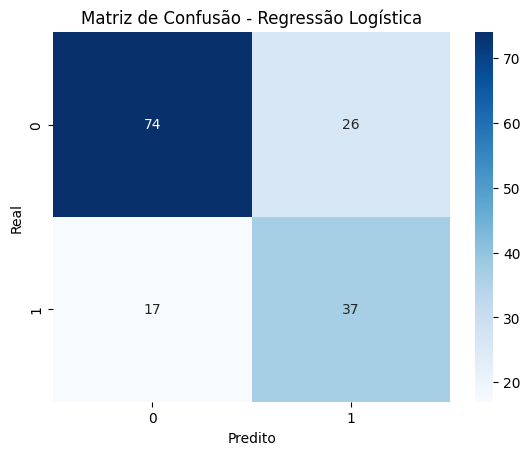

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



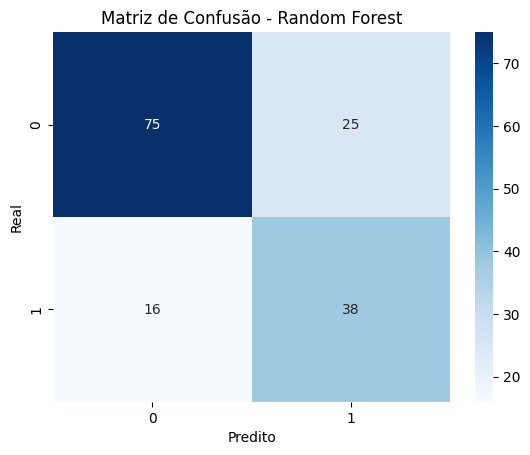

In [38]:
def avaliar_modelo(y_true, y_pred, modelo_name):
    print(f"Resultados para {modelo_name}:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão - {modelo_name}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()
    
avaliar_modelo(y_test, y_pred_lr, "Regressão Logística")
avaliar_modelo(y_test, y_pred_rf, "Random Forest")

Agora que finalizamos a parte de análise, limpeza/normalização e treinamento,
vamos testar o modelo!

In [39]:
# Carregar dataset original novamente (apenas para referencias e medianas)
#Essas medianas são usadas para preencher valores nulos (ou zeros) inseridos pelo usuário.
df = pd.read_csv('../data/diabetes.csv')


Aqui, carregamos os modelos e o escalonador que foram treinados e salvos anteriormente.
O joblib é usado para ler esses arquivos .pkl que contêm os modelos prontos.

In [40]:
# Carregar modelos e scaler salvos (insira o diretório)
lr = joblib.load('../outputs/lr_model.pkl')
rf = joblib.load('../outputs/rf_model.pkl')
scaler = joblib.load('../outputs/scaler.pkl')

Esta função serve para o usuário digitar manualmente os dados de um novo paciente.
Ela cria um DataFrame com as mesmas colunas do dataset original e realiza o mesmo pré-processamento
que foi feito no momento do treinamento

In [ ]:
# Função para inserir dados do paciente
def inserir_dados_paciente():
    print("Insira os dados do paciente:")
    Pregnancies = int(input("Número de gestações: "))
    Glucose = float(input("Glicose (mg/dL): "))
    BloodPressure = float(input("Pressão arterial (mmHg): "))
    SkinThickness = float(input("Espessura da pele (mm): "))
    Insulin = float(input("Insulina (µU/mL): "))
    BMI = float(input("IMC (BMI): "))
    DiabetesPedigreeFunction = float(input("Função de pedigree diabético (1 para sim, 0 para não): "))
    Age = int(input("Idade: "))
    
    paciente = pd.DataFrame({
        'Pregnancies':[Pregnancies],
        'Glucose':[Glucose],
        'BloodPressure':[BloodPressure],
        'SkinThickness':[SkinThickness],
        'Insulin':[Insulin],
        'BMI':[BMI],
        'DiabetesPedigreeFunction':[DiabetesPedigreeFunction],
        'Age':[Age]
    })
    
    # Tratar zeros e imputar mediana
    cols_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
    paciente[cols_zero] = paciente[cols_zero].replace(0, np.nan)
    paciente.fillna(df.median(), inplace=True)
    
    # Escalonar
    paciente_scaled = scaler.transform(paciente)
    
    return paciente_scaled

In [42]:
# Inserir paciente / chamando a funcao
novo_paciente_scaled = inserir_dados_paciente()

Insira os dados do paciente:


In [43]:
# criando um dicionario com os dois modelos treinados
modelos = {'Regressao Logistica': lr, 'Random Forest': rf}

 --------------- Realizando as Predições ----------------   
 Para cada modelo, o código faz:
- A previsão (0 = Não Diabetes, 1 = Diabetes)
- Calcula as probabilidades de cada classe
- Exibe o resultado formatado

In [44]:
for nome, modelo in modelos.items():
    resultado = modelo.predict(novo_paciente_scaled)
    proba = modelo.predict_proba(novo_paciente_scaled)
    
    print(f"\n===== {nome} =====")
    print("Predição:", "Diabetes" if resultado[0]==1 else "Não Diabetes")
    
    # Exibir probabilidades de forma legível
    classes = ['Não Diabetes', 'Diabetes']
    proba_percent = [f"{classes[i]}: {p*100:.2f}%" for i, p in enumerate(proba[0])]
    print("Probabilidades:")
    for p in proba_percent:
        print(p)


===== Regressao Logistica =====
Predição: Não Diabetes
Probabilidades:
Não Diabetes: 100.00%
Diabetes: 0.00%

===== Random Forest =====
Predição: Não Diabetes
Probabilidades:
Não Diabetes: 58.00%
Diabetes: 42.00%
